## Data mining questions

1- Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?
- no because they cant preserve information from from previous timesteps
- not better than the cnn but it can be used with it and we can combine them together (CNN-FCL) and has proven to be very effective for image classification. However, it should be noted that fully-connected models can be prone to overfitting



2- What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?

- These problems arise when gradients become too small or too large during backpropagation, which can lead to slow or unstable learning.
- To mitigate these problems, LSTM and GRU networks use a gating mechanism that allows them to selectively remember or forget information from previous time steps.

---


3- What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?
- multi-objective/multi-task learning training of a neural network to perform multiple related tasks simultaneously
- Multi-modality learning (MML) refers to the training of a neural network to learn from multiple modalities of data, such as images, speech, text, or other types of input
---

4- What is the difference among xgboost, lightgbm and catboost

- each of these frameworks has its own strengths and weaknesses
- Speed : LightGBM and CatBoost are typically faster than XGBoost
- Memory usage : LightGBM and CatBoost are designed to use less memory than XGBoost.
- Handling categorical features: CatBoost is specifically designed to handle categorical features more effectively than XGBoost or LightGBM
- Regularization : LightGBM and CatBoost both offer additional regularization techniques that are not available in XGBoost

# problem formulation
</br>

### problem definition

- our problem here is about building a model to classify the price, our inputs here are summary and image (7627) for a training dataset and the output is price(7627).
---

### Data mining function
- text preprocessing -> tokenization and vectorization each text ->training the model -> classification and prediction.

---

### Challenges

- We have a very big data set so maybe will take some time to preprocess it and train it.

- imbalanced labels distribution.
- The size of training dataset is smaller that test dataset
---

### Model impact

- Predicting the actual price class beginner, plus, premium

---

### The ideal solution

- by only using the text and not using images i got the highest score


## Experimental protocol

### Data preprocessing
---
- cleaning input data for both training set and test set using stemming 
- (tried translating but it got lower accuracy)
- tokenizing
- loading images and resizing it
---
### Building models

- trying different neural network architecture then try to tune hyperparameters of the best one

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D,GlobalMaxPooling1D, Dense, MaxPool2D, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras import regularizers
import nltk 
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from PIL import Image
from keras.callbacks import ReduceLROnPlateau

# !pip install googletrans
# !pip install googletrans==3.1.0a0 --user
from tqdm.notebook import tqdm
# from googletrans import Translator

In [3]:
train_df = pd.read_csv("train_xy.csv")
test_df = pd.read_csv("test_x.csv")

In [4]:
train_df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [5]:
test_df

,id,summary,image
0,0,Charming warm house is ready to host you here ...,img_test/0.jpg
1,1,"La chambre est spacieuse et lumineuse, dans un...",img_test/1.jpg
2,2,Grande chambre confortable située au sous-sol ...,img_test/2.jpg
3,3,"Près d’un Métro, ligne orange. 10 minutes à pi...",img_test/3.jpg
4,4,Very bright appartment and very cosy. 2 separa...,img_test/4.jpg
...,...,...,...
7355,7626,"Large, fully-furnished flat with brick walls a...",img_test/7627.jpg
7356,7627,Logement situé dans le haut d’un duplex. Vivez...,img_test/7628.jpg
7357,7628,"My place is close to parks, . My place is good...",img_test/7629.jpg
7358,7629,"*** For security reasons, I will prioritize gu...",img_test/7630.jpg


In [6]:
train_df[['summary','image','type']].describe()

,summary,image,type
count,7326,7627,7627
unique,6844,7627,24
top,"Featured in The New York Times, The Wall Stree...",img_train/0.jpg,Apartment
freq,88,1,5765


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7627 entries, 0 to 7626
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  7326 non-null   object
 1   image    7627 non-null   object
 2   type     7627 non-null   object
 3   price    7627 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


In [8]:
train_df['price'].value_counts()

0    4737
1    2403
2     487
Name: price, dtype: int64

In [9]:
train_df.isnull().sum()

summary    301
image        0
type         0
price        0
dtype: int64

In [10]:
train_df.dropna(inplace=True)
train_df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [11]:
train_df.isnull().sum()

summary    0
image      0
type       0
price      0
dtype: int64

In [12]:
train_df.duplicated().sum()

0

i translated the dataset then saved it so i dont have to run it each time

In [13]:
# 
# #translate the summary column for both datasets
# for i in tqdm(range(len(train_df))):
#     translator = Translator()
#     train_df.at[i,'summary'] = translator.translate(train_df.at[i,'summary'] , dest='en').text
    
# print("Done train_df..\n")
    
# for i in tqdm(range(len(test_df))):
#     translator = Translator()
#     test_df.at[i,'summary'] = translator.translate(test_df.at[i,'summary'] , dest='en').text
# print("Done test_df..\n")

# train_df.to_csv('train_df.csv', index=False)
# test_df.to_csv('test_df.csv', index=False)

# train_df = pd.read_csv("train_df.csv")
# test_df = pd.read_csv("test_df.csv")

In [14]:
train_df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [15]:
test_df

,id,summary,image
0,0,Charming warm house is ready to host you here ...,img_test/0.jpg
1,1,"La chambre est spacieuse et lumineuse, dans un...",img_test/1.jpg
2,2,Grande chambre confortable située au sous-sol ...,img_test/2.jpg
3,3,"Près d’un Métro, ligne orange. 10 minutes à pi...",img_test/3.jpg
4,4,Very bright appartment and very cosy. 2 separa...,img_test/4.jpg
...,...,...,...
7355,7626,"Large, fully-furnished flat with brick walls a...",img_test/7627.jpg
7356,7627,Logement situé dans le haut d’un duplex. Vivez...,img_test/7628.jpg
7357,7628,"My place is close to parks, . My place is good...",img_test/7629.jpg
7358,7629,"*** For security reasons, I will prioritize gu...",img_test/7630.jpg


In [16]:
nltk.download('punkt') # punkt is a tokenizer uses an unsupervised algorithm to divide a text into a list of sentences.
nltk.download('stopwords') # download english stopwords

stemmer = SnowballStemmer("english")   # It is the method used to return the word to its original form
stop_words = set(stopwords.words("english")) # It is the method of producing a stop words

def clean_text(text):

    # IGNORECASE : is a flag allows for case-insensitive matching of the Regular Expression with the given string
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) # Remove any more than one space
    RE_TAGS = re.compile(r"<[^>]+>") # Remove web tags
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # Remove any leter does not english charachter
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE) # Remove any single character

    text = re.sub(RE_TAGS, " ", text)# Replace any tag with a single space.
    text = re.sub(RE_ASCII, " ", text) # Replace any non english character with a single space.
    text = re.sub(RE_SINGLECHAR, " ", text) # Replace any single character with a single space.
    text = re.sub(RE_WSPACE, " ", text)  # Replace any more than one space with a single space.

    word_tokens = word_tokenize(text) # split the sentence into words
    words_tokens_lower = [word.lower() for word in word_tokens] # Convert all letters to small letters

    # words_filtered (Words can be filtered based on how many times they appear)
    # stemmer used to return the word to its original form.
    words_filtered = [
        stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
    ]

    # Join all words in text_clean and separate them by space.
    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to C:\Users\Omar
[nltk_data]     Sameh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Omar
[nltk_data]     Sameh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
train_df["summary"] = train_df["summary"].map(lambda x: clean_text(x) if isinstance(x, str) else x).copy() ## clean and lemmatiz training set
test_df["summary"] = test_df["summary"].map(lambda x: clean_text(x) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set

In [18]:
train_df

,summary,image,type,price
0,spacious sunni cozi modern apart heart montrea...,img_train/0.jpg,Apartment,1
1,locat one vibrant access locat downtown montre...,img_train/1.jpg,Apartment,0
2,logement coquet et douillet minut du centr vil...,img_train/2.jpg,Apartment,1
3,beauti spacious sc ft mc condo th floor west i...,img_train/3.jpg,Apartment,1
4,très grand appart rustiqu et très agréabl vivr...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,un grand logement et tout inclut bien éclairé ...,img_train/7626.jpg,Apartment,0
7623,magnific condo direct river sleep song wild bi...,img_train/7627.jpg,Apartment,2
7624,apart perfect anyon visit citi locat eclect ne...,img_train/7628.jpg,Apartment,1
7625,cozi clean comfort apart heart downtown websit...,img_train/7629.jpg,Apartment,0


In [19]:
test_df

,id,summary,image
0,0,charm warm hous readi host multi cultur parc e...,img_test/0.jpg
1,1,la chambr est spacieus et lumineus dan un appa...,img_test/1.jpg
2,2,grand chambr confort situé au sous sol de notr...,img_test/2.jpg
3,3,près un métro lign orang minut pie quartier ré...,img_test/3.jpg
4,4,bright appart cosi separ bedroom queen size do...,img_test/4.jpg
...,...,...,...
7355,7626,larg fulli furnish flat brick wall hardwood fl...,img_test/7627.jpg
7356,7627,logement situé dan le haut un duplex vivez le ...,img_test/7628.jpg
7357,7628,place close park place good coupl,img_test/7629.jpg
7358,7629,secur reason priorit guest review thank unders...,img_test/7630.jpg


# Images preprocessing

In [20]:
def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64)) # read each image as a greyscale image size (64x64x2)
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64,2))       # if an image can't be loaded, return an array of zeros (same size: 64x64x2)
    return arr

In [21]:
# loading images:
x_train_image = np.array([load_image(i) for i in tqdm(train_df['image'])])

  0%|          | 0/7326 [00:00<?, ?it/s]

In [22]:
x_test_image = np.array([load_image(i) for i in tqdm(test_df['image'])])

  0%|          | 0/7360 [00:00<?, ?it/s]

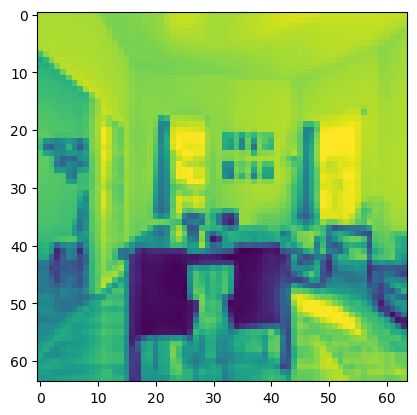

In [23]:
plt.imshow(x_train_image[0, :, :, 0])

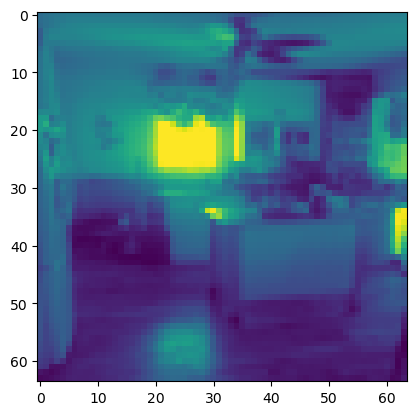

In [24]:
plt.imshow(x_test_image[0, :, :, 0])

In [25]:
train_df.summary = train_df.summary.astype('str')
test_df.summary = test_df.summary.astype('str')

In [26]:
train_df["type"]

0       Apartment
1       Apartment
2       Apartment
3       Apartment
4       Apartment
          ...    
7622    Apartment
7623    Apartment
7624    Apartment
7625    Apartment
7626        House
Name: type, Length: 7326, dtype: object

In [27]:
train_df['type'] = train_df['type'].astype('category').cat.codes
train_df

,summary,image,type,price
0,spacious sunni cozi modern apart heart montrea...,img_train/0.jpg,1,1
1,locat one vibrant access locat downtown montre...,img_train/1.jpg,1,0
2,logement coquet et douillet minut du centr vil...,img_train/2.jpg,1,1
3,beauti spacious sc ft mc condo th floor west i...,img_train/3.jpg,1,1
4,très grand appart rustiqu et très agréabl vivr...,img_train/4.jpg,1,0
...,...,...,...,...
7622,un grand logement et tout inclut bien éclairé ...,img_train/7626.jpg,1,0
7623,magnific condo direct river sleep song wild bi...,img_train/7627.jpg,1,2
7624,apart perfect anyon visit citi locat eclect ne...,img_train/7628.jpg,1,1
7625,cozi clean comfort apart heart downtown websit...,img_train/7629.jpg,1,0


In [28]:
# get type 
y_train_type = train_df.type

# get price
y_train_price = train_df.price
x_train_text = train_df.summary.astype('str')

In [29]:
vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    

# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)
x_test_text = _preprocess(test_df['summary'].astype('str'))

print(x_train_text_id.shape)
print(x_test_text.shape)


(7326, 100)
(7360, 100)


In [30]:
print(tokenizer.sequences_to_texts(x_test_text[:1]))


['charm warm hous readi host multi cultur parc ex short walk parc jarri watch roger cup major bus line metro downtown']


In [31]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


In [32]:
#first output shape
len_type = len(train_df.type.unique())
#second output shape
len_price = len(train_df.price.unique())

In [33]:
len_type

24

In [34]:
len_price

3

# Trial 1
## Text part
- Embedding layer
- Average layer
- Dropout = 50% to reduce overfitting.
## Image part
- Convolutional layer with 32 filters, and a 16*16 mask
- Max pooling with a 16*16 mask
- Flatten layer

In [114]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)# embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
averaged= Dropout(0.5)(averaged)# 50% dropout

# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16*16 mask
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     4000000     ['input_5[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 49, 49, 32)   16416       ['input_6[0][0]']                
                                                                                            

In [125]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # If val_price_loss is raised 5 times, the fit will be stopped.
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 2s 6ms/step - loss: 7.1954 - price_loss: 3.2707 - type_loss: 11.1201 - price_sparse_categorical_accuracy: 0.7416 - type_sparse_categorical_accuracy: 0.7655 - val_loss: 7.3366 - val_price_loss: 5.1572 - val_type_loss: 9.5160 - val_price_sparse_categorical_accuracy: 0.5327 - val_type_sparse_categorical_accuracy: 0.7224
Epoch 2/20
367/367 [==============================] - 2s 6ms/step - loss: 2.8518 - price_loss: 1.4312 - type_loss: 4.2725 - price_sparse_categorical_accuracy: 0.7952 - type_sparse_categorical_accuracy: 0.8324 - val_loss: 5.9604 - val_price_loss: 3.6700 - val_type_loss: 8.2508 - val_price_sparse_categorical_accuracy: 0.6105 - val_type_sparse_categorical_accuracy: 0.6760
Epoch 3/20
367/367 [==============================] - 2s 6ms/step - loss: 1.5868 - price_loss: 0.9380 - type_loss: 2.2356 - price_sparse_categorical_accuracy: 0.8266 - type_sparse_categorical_accuracy: 0.8519 - val_loss: 5.7362 - val_price_loss: 3.5045 - 

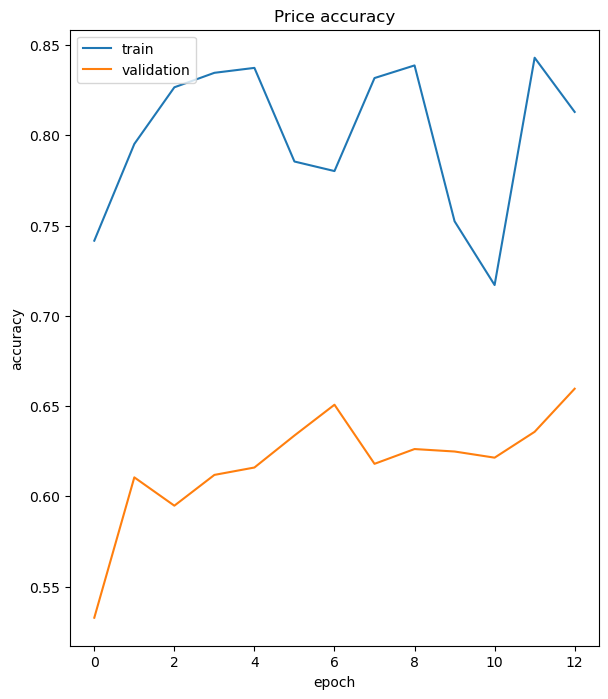

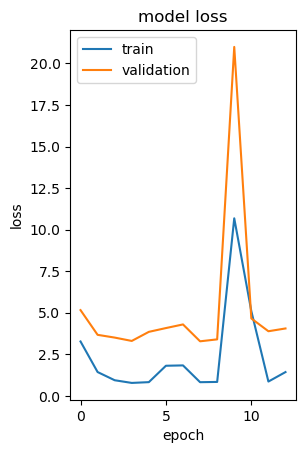

In [126]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [127]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 0s 2ms/step
[[9.88772213e-01 6.12183067e-04 1.06155155e-02]
 [1.00000000e+00 2.46279941e-11 7.85349054e-24]
 [1.00000000e+00 4.15364019e-14 9.62067094e-19]
 ...
 [9.99847174e-01 6.25651301e-05 9.02182874e-05]
 [1.00000000e+00 3.33543999e-16 9.76534689e-28]
 [9.99998689e-01 1.32562946e-06 1.37664775e-11]]
[0 0 0 ... 0 0 0]


In [128]:
np.unique(first_prediction)

array([0, 1, 2], dtype=int64)

In [130]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': first_prediction}
).to_csv('st1_1.csv', index=False)

kaggle:0.651

# Trial 2
 I added a LSTM layer and conv1D between the embedded layer and averaged layer this should increase the accuracy
## Text part
- Embedding layer
- lstm layer
- conv1D
- Dropout = 50% to reduce overfitting.
## Image part
- Convolutional layer with 32 filters, and a 16*16 mask, no padding
- Max pooling with a 16*16 mask
- Flatten layer

In [137]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# Add an embedding layer to convert the input indices to dense vectors
embedding_layer = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)

# Add a LSTM layer with 64 units and L2 regularization
lstm_layer = LSTM(units=64, kernel_regularizer=regularizers.l2(0.01))(embedding_layer)

# Add a 1D convolutional layer with 128 filters and a kernel size of 3, and L2 regularization
conv_layer = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedding_layer)

# Add a global max pooling layer to extract the most important features
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Add a dropout layer to prevent overfitting
dropout_layer = Dropout(rate=0.5)(lstm_layer)

cov = Conv2D(32, (16, 16))(in_image) # convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov) # max pooling with a 16*16 mask
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([dropout_layer, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 100)     4000000     ['input_13[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 49, 49, 32)   16416       ['input_14[0][0]']               
                                                                                            

In [140]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # If val_price_loss is raised 5 times, the fit will be stopped.
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 5s 14ms/step - loss: 10.7725 - price_loss: 7.6457 - type_loss: 13.8993 - price_sparse_categorical_accuracy: 0.5300 - type_sparse_categorical_accuracy: 0.5968 - val_loss: 5.8673 - val_price_loss: 4.5905 - val_type_loss: 7.1441 - val_price_sparse_categorical_accuracy: 0.4891 - val_type_sparse_categorical_accuracy: 0.7149
Epoch 2/20
367/367 [==============================] - 4s 12ms/step - loss: 23.9897 - price_loss: 17.8881 - type_loss: 30.0913 - price_sparse_categorical_accuracy: 0.5275 - type_sparse_categorical_accuracy: 0.5923 - val_loss: 27.0123 - val_price_loss: 13.4626 - val_type_loss: 40.5620 - val_price_sparse_categorical_accuracy: 0.5512 - val_type_sparse_categorical_accuracy: 0.7667
Epoch 3/20
367/367 [==============================] - 4s 12ms/step - loss: 15.3758 - price_loss: 8.6375 - type_loss: 22.1140 - price_sparse_categorical_accuracy: 0.5268 - type_sparse_categorical_accuracy: 0.6012 - val_loss: 11.4046 - val_price_lo

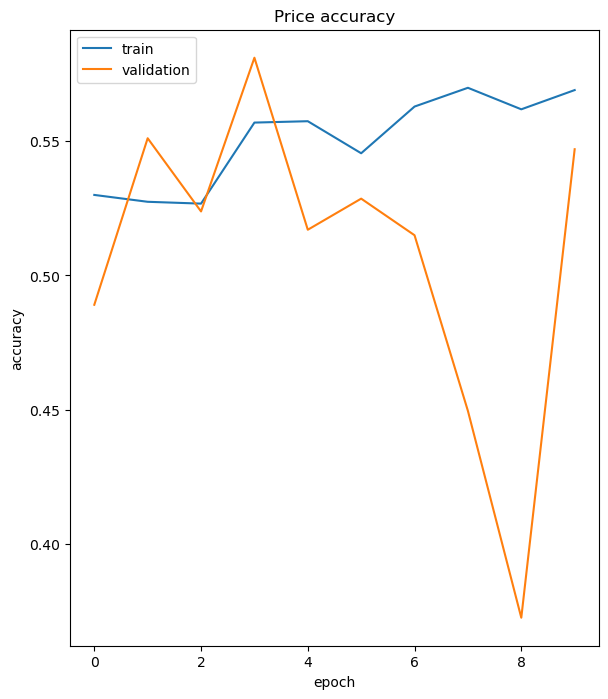

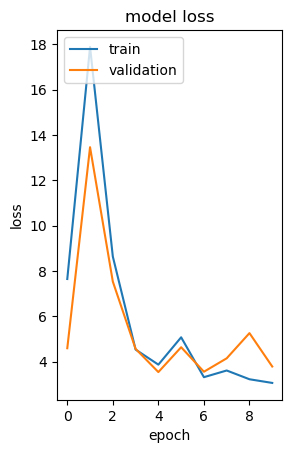

In [141]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

sadly it didn't :(

# Trial 3
## Text part
- Embedding layer
- Bidirectional gru layer
- Dropout = 0.50% to reduce overfitting.
## Image part
- Convolutional layer
- Max pooling 
- Flatten layer

In [156]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)# embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
gru= Bidirectional(GRU(128, activation='tanh'))(embedded)
gru= Dropout(0.5)(gru)


# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image)# convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov)# max pooling with a 16*16 mask
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([gru, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 100, 100)     4000000     ['input_19[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 49, 49, 32)   16416       ['input_20[0][0]']               
                                                                                            

In [157]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # If val_price_loss is raised 5 times, the fit will be stopped.
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 9s 20ms/step - loss: 20.0005 - price_loss: 15.6456 - type_loss: 24.3553 - price_sparse_categorical_accuracy: 0.5104 - type_sparse_categorical_accuracy: 0.5797 - val_loss: 15.1511 - val_price_loss: 15.6591 - val_type_loss: 14.6432 - val_price_sparse_categorical_accuracy: 0.4216 - val_type_sparse_categorical_accuracy: 0.7285
Epoch 2/20
367/367 [==============================] - 7s 18ms/step - loss: 7.8966 - price_loss: 5.9506 - type_loss: 9.8427 - price_sparse_categorical_accuracy: 0.5480 - type_sparse_categorical_accuracy: 0.6119 - val_loss: 5.5824 - val_price_loss: 4.8171 - val_type_loss: 6.3477 - val_price_sparse_categorical_accuracy: 0.5409 - val_type_sparse_categorical_accuracy: 0.6583
Epoch 3/20
367/367 [==============================] - 7s 19ms/step - loss: 5.5692 - price_loss: 3.7655 - type_loss: 7.3730 - price_sparse_categorical_accuracy: 0.5850 - type_sparse_categorical_accuracy: 0.6433 - val_loss: 4.1524 - val_price_loss: 3

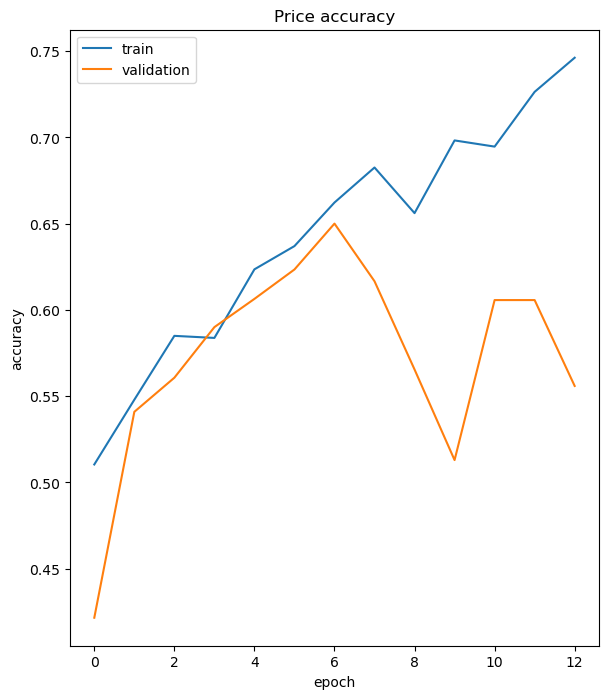

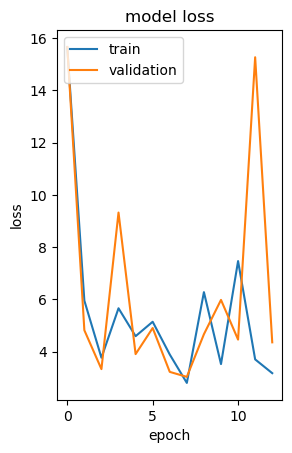

In [158]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Trial 4
## Text part
- Embedding layer
- averaged layer
## Image part
- Convolutional layer
- Max pooling 
- Dropout = 0.30% 
- Flatten layer

In [179]:
# Two inputs, one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)# embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded


# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image)  # convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov)  # max pooling with a 16*16 mask
pl=Dropout(0.3)(pl) # 30% dropout
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()
     

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 49, 49, 32)   16416       ['input_40[0][0]']               
                                                                                                  
 input_39 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 3, 3, 32)    0           ['conv2d_16[0][0]']              
 )                                                                                         

In [180]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, ) # If val_price_loss is raised 5 times, the fit will be stopped.
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 3s 7ms/step - loss: 35.9653 - price_loss: 32.3222 - type_loss: 39.6083 - price_sparse_categorical_accuracy: 0.4881 - type_sparse_categorical_accuracy: 0.5515 - val_loss: 9.9299 - val_price_loss: 6.3754 - val_type_loss: 13.4845 - val_price_sparse_categorical_accuracy: 0.5314 - val_type_sparse_categorical_accuracy: 0.6951
Epoch 2/20
367/367 [==============================] - 2s 6ms/step - loss: 19.0457 - price_loss: 16.7007 - type_loss: 21.3907 - price_sparse_categorical_accuracy: 0.4930 - type_sparse_categorical_accuracy: 0.5597 - val_loss: 12.2936 - val_price_loss: 8.6568 - val_type_loss: 15.9304 - val_price_sparse_categorical_accuracy: 0.6201 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 3/20
367/367 [==============================] - 2s 6ms/step - loss: 14.2322 - price_loss: 10.6558 - type_loss: 17.8086 - price_sparse_categorical_accuracy: 0.5003 - type_sparse_categorical_accuracy: 0.5724 - val_loss: 4.9064 - val_price_loss

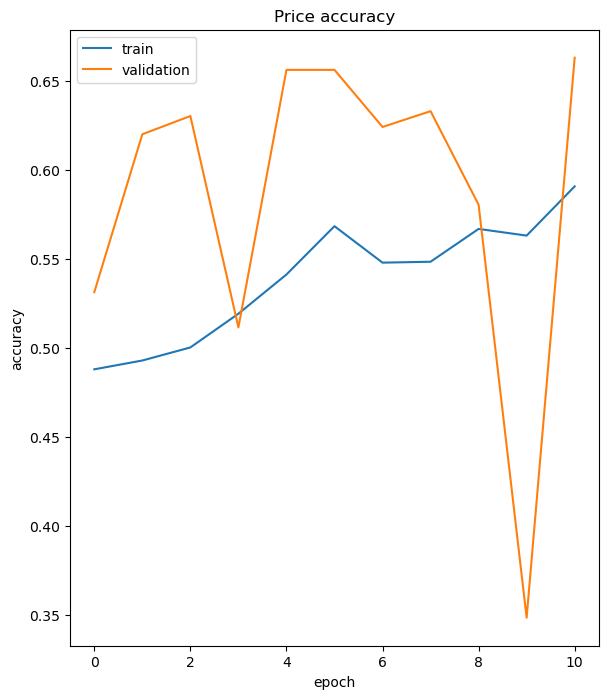

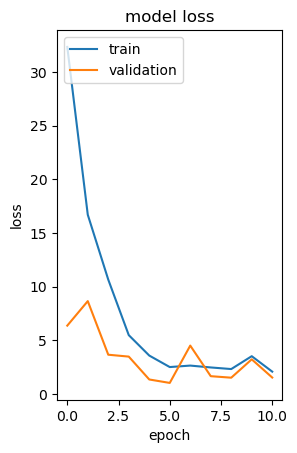

In [181]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [182]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 0s 2ms/step
[[9.8815793e-01 1.1841090e-02 9.1067483e-07]
 [9.9947256e-01 5.2735774e-04 9.5062347e-08]
 [9.9291307e-01 7.0862840e-03 6.6385485e-07]
 ...
 [9.8939043e-01 1.0609255e-02 3.0253909e-07]
 [9.9961227e-01 3.8727061e-04 5.1684066e-07]
 [9.6535891e-01 3.4637064e-02 4.0246346e-06]]
[0 0 0 ... 0 0 0]


In [183]:
np.unique(first_prediction)

array([0, 1], dtype=int64)

In [184]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': first_prediction}
).to_csv('t4_1.csv', index=False)

kaggle:0.649

# Trial 5
## Text part
- Embedding layer
- averaged layer
## Image part
- Convolutional layer
- Max pooling 
- Flatten layer

In [240]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded


# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
cov = Conv2D(32, (16, 16))(in_image)# convolutional layer with 32 filters, and a 16*16 mask, no padding
pl = MaxPool2D((16, 16))(cov)# max pooling with a 16*16 mask
flattened = Flatten()(pl) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()
     

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_49 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 49, 49, 32)   16416       ['input_50[0][0]']               
                                                                                                  
 embedding_24 (Embedding)       (None, 100, 100)     4000000     ['input_49[0][0]']               
                                                                                           

In [248]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)


Epoch 1/20
367/367 [==============================] - 3s 7ms/step - loss: 3.0615 - price_loss: 1.8953 - type_loss: 4.2277 - price_sparse_categorical_accuracy: 0.7200 - type_sparse_categorical_accuracy: 0.7232 - val_loss: 4.3964 - val_price_loss: 2.7836 - val_type_loss: 6.0092 - val_price_sparse_categorical_accuracy: 0.5723 - val_type_sparse_categorical_accuracy: 0.7633
Epoch 2/20
367/367 [==============================] - 2s 6ms/step - loss: 2.5437 - price_loss: 1.6876 - type_loss: 3.3998 - price_sparse_categorical_accuracy: 0.7265 - type_sparse_categorical_accuracy: 0.7418 - val_loss: 3.8625 - val_price_loss: 2.8731 - val_type_loss: 4.8519 - val_price_sparse_categorical_accuracy: 0.5607 - val_type_sparse_categorical_accuracy: 0.6160
Epoch 3/20
367/367 [==============================] - 2s 6ms/step - loss: 2.5985 - price_loss: 1.7290 - type_loss: 3.4680 - price_sparse_categorical_accuracy: 0.7299 - type_sparse_categorical_accuracy: 0.7348 - val_loss: 4.2468 - val_price_loss: 2.9357 - v

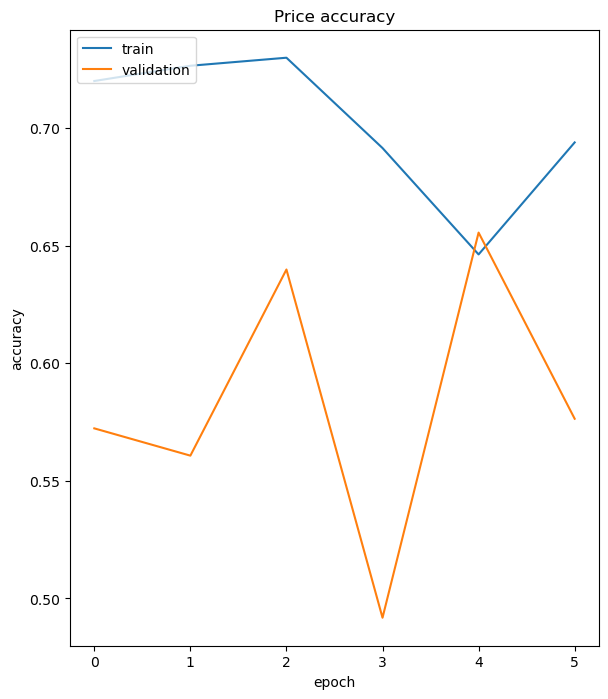

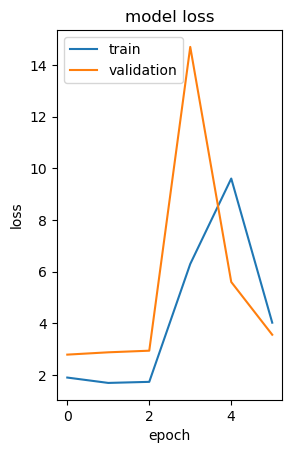

In [249]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Trial 6
## the last trial made me notice there is a problem with images so i decided to try text only model with no images

In [62]:
# Two inputs, one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
averaged= Dropout(0.5)(averaged)# 50% dropout




# fusion - combinig both the text and the image
fused = averaged

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                                  
 tf.math.reduce_mean_2 (TFOpLam  (None, 100)         0           ['embedding_2[0][0]']            
 bda)                                                                                             
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['tf.math.reduce_mean_2[0][

In [63]:
history = model.fit(
    x={
        'summary': x_train_text_id    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)


Epoch 1/20
367/367 [==============================] - 3s 6ms/step - loss: 1.1993 - price_loss: 0.8766 - type_loss: 1.5220 - price_sparse_categorical_accuracy: 0.6101 - type_sparse_categorical_accuracy: 0.7399 - val_loss: 0.8908 - val_price_loss: 0.8153 - val_type_loss: 0.9663 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 2/20
367/367 [==============================] - 2s 5ms/step - loss: 0.9160 - price_loss: 0.8238 - type_loss: 1.0082 - price_sparse_categorical_accuracy: 0.6206 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 0.8706 - val_price_loss: 0.7996 - val_type_loss: 0.9416 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 3/20
367/367 [==============================] - 2s 5ms/step - loss: 0.8953 - price_loss: 0.8080 - type_loss: 0.9826 - price_sparse_categorical_accuracy: 0.6256 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 0.8552 - val_price_loss: 0.7855 - v

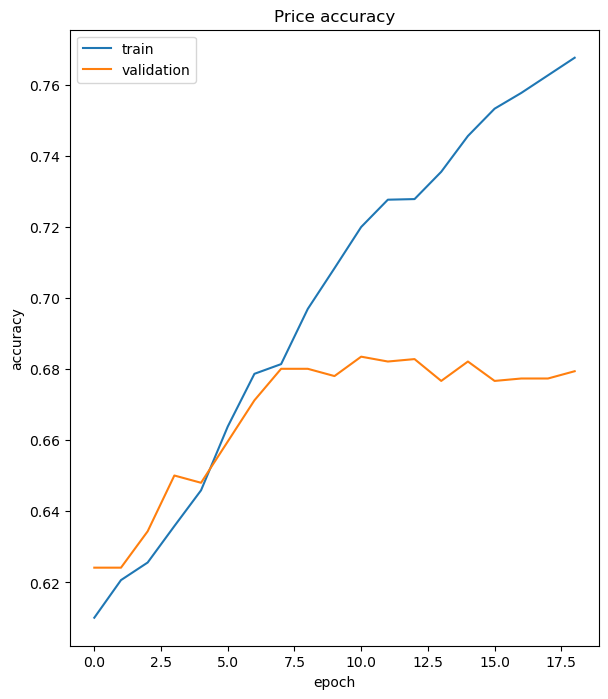

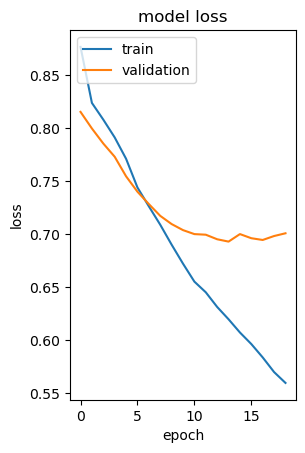

In [64]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [65]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 0s 1ms/step
[[0.6321651  0.26958784 0.0982471 ]
 [0.9642659  0.02908899 0.00664512]
 [0.8461439  0.10339867 0.05045744]
 ...
 [0.7775766  0.18513928 0.0372841 ]
 [0.96580726 0.02445399 0.00973877]
 [0.7511028  0.20811358 0.04078358]]
[0 0 0 ... 0 0 0]


In [66]:
np.unique(first_prediction)

array([0, 1, 2], dtype=int64)

In [67]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': first_prediction}
).to_csv('noImg2.csv', index=False)

### kaggle 0.68614 

# bonus trials DenseNet201 pretrained (with rgb pics) 

In [96]:
def load_resize_image(file_path):
    try:
        image = Image.open(file_path).resize((64, 64))
        image_rgb = image.convert('RGB') # convert the image to RGB format if necessary
        return np.array(image_rgb)
    except:
        return np.zeros((64, 64, 3)) # return an array of zeros if the image cannot be loaded

# Load and resize the images in the training data


In [97]:
x_train_image2 = np.array([load_resize_image(i) for i in tqdm(train_df['image'])])

  0%|          | 0/7326 [00:00<?, ?it/s]

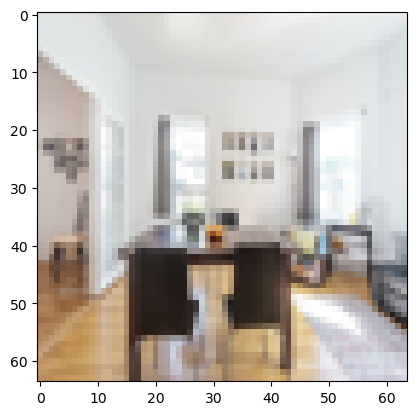

In [122]:
first_image = x_train_image2[0]

# Display the image using imshow()

# Normalize the pixel values to the range [0, 1]
normalized_image = first_image / 255.0

# Display the normalized image using imshow()
plt.imshow(normalized_image)
plt.show()

In [143]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 3))

# text part
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
averaged= Dropout(0.5)(averaged)# 50% dropout



# image part 
# Conv2D is a two-dimensional convolution layer that generates a tensor of outputs by winding a convolution kernel with the layers input
# MaxPool2D used to reduces the dimensionality of images that is  by reducing the number of pixels in the output from the previous convolutional layer.
from keras.applications.densenet import DenseNet201
base_model = DenseNet201(weights='imagenet',include_top=False)

x = base_model.output
x = tf.keras.layers.Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
flattened = Flatten()(x) # flatten the shape to (288,)

# fusion - combinig both the text and the image
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task(type and price)
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': base_model.input
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['input_37[0][0]']               
 2D)                            3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_12[0][0]']      
                                64)                                                        

In [144]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image2
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_price_loss', factor=0.2, patience=3, min_lr=1e-6)

    ],
    verbose=1
)


Epoch 1/100
367/367 [==============================] - 48s 96ms/step - loss: 1.1642 - price_loss: 0.8825 - type_loss: 1.4460 - price_sparse_categorical_accuracy: 0.5874 - type_sparse_categorical_accuracy: 0.6795 - val_loss: 1.1062 - val_price_loss: 0.8807 - val_type_loss: 1.3318 - val_price_sparse_categorical_accuracy: 0.6228 - val_type_sparse_categorical_accuracy: 0.7019 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - 35s 94ms/step - loss: 0.9144 - price_loss: 0.8174 - type_loss: 1.0114 - price_sparse_categorical_accuracy: 0.6218 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 1.0523 - val_price_loss: 1.0901 - val_type_loss: 1.0146 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7626 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - 34s 92ms/step - loss: 0.8933 - price_loss: 0.8013 - type_loss: 0.9853 - price_sparse_categorical_accuracy: 0.6280 - type_sparse_categorical_accuracy: 0.7558 - val_loss: 

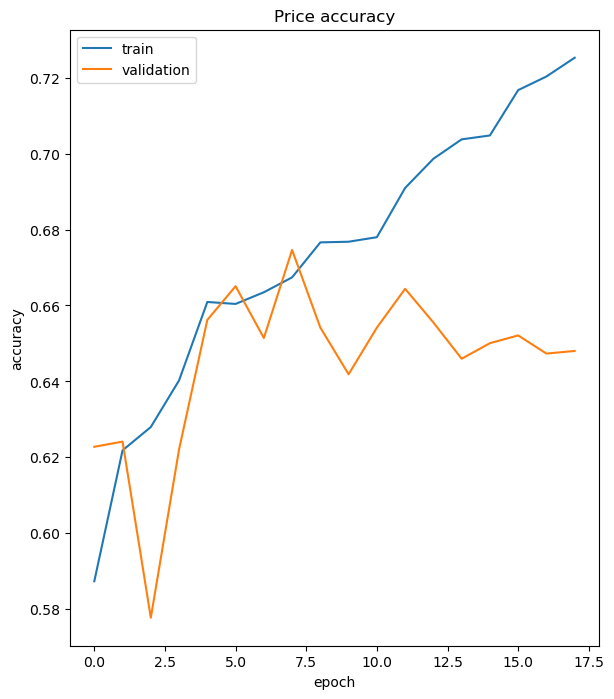

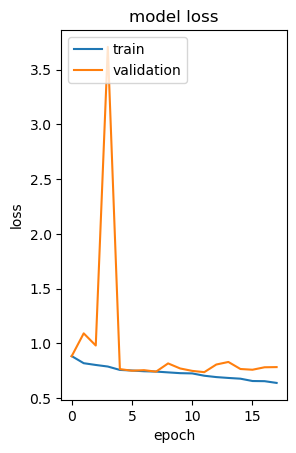

In [145]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['price_sparse_categorical_accuracy'])
plt.plot(history.history['val_price_sparse_categorical_accuracy'])
plt.title('Price accuracy') # graph title
plt.ylabel('accuracy') # y axis lable
plt.xlabel('epoch') # x axis lable
plt.legend(['train', 'validation'], loc='upper left') # legend is an area describing the elements of the graph
plt.show()
plt.grid(True) # grid is the axis object's method toggles the visibility of the grid inside the figure.
plt.subplot(1, 2, 1)
plt.plot(history.history['price_loss'])
plt.plot(history.history['val_price_loss'])
plt.title('model loss')  # graph title
plt.ylabel('loss') # y axis lable
plt.xlabel('epoch')# x axis lable
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [124]:
x_test_image2 = np.array([load_resize_image(i) for i in tqdm(test_df['image'])])

  0%|          | 0/7360 [00:00<?, ?it/s]

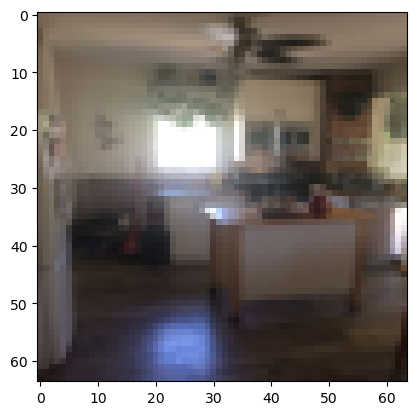

In [125]:
first_image = x_test_image2[0]

# Display the image using imshow()

# Normalize the pixel values to the range [0, 1]
normalized_image = first_image / 255.0

# Display the normalized image using imshow()
plt.imshow(normalized_image)
plt.show()

In [140]:
#start predicting the values of type and price using summary and image as inputs
first_prediction = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image2
    }
)


# probabilities
first_prediction = first_prediction['price']
print(first_prediction)

# categories
first_prediction = np.argmax(first_prediction, axis=1)
print(first_prediction)

230/230 [==============================] - 7s 30ms/step
[[0.7493462  0.20837262 0.04228109]
 [0.90831953 0.07675888 0.01492153]
 [0.7729495  0.18534738 0.04170312]
 ...
 [0.79758286 0.17168072 0.0307365 ]
 [0.87570184 0.09948964 0.02480846]
 [0.73550546 0.19529106 0.06920352]]
[0 0 0 ... 0 0 0]


In [141]:
np.unique(first_prediction)

array([0, 1, 2], dtype=int64)

In [142]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': first_prediction}
).to_csv('dense3.csv', index=False)

highest try on kaggle was 0.679

# keras tuner

In [40]:
import keras_tuner as kt
in_text = keras.Input(batch_shape=(None, max_len))

def tun(hp):
    keras.backend.clear_session()
    

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-6])# tuning the  learning rate 
    units_1 = hp.Float('hidden_1', min_value=0, max_value=1, step=0.05,default=0.5)# tuning the  learning rate 
    hidden_dropout =  hp.Float('hidden_dropout',min_value=0.0,max_value=0.75,default=0.25,step=0.05)

    # text part
    embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text) # embedding requires to encoded input data to integer encoded, so that each word is represented by a unique integer
    averaged = tf.reduce_mean(embedded, axis=1)  # reduce_mean that compute the mean value of embeddded
    averaged= Dropout(rate = hidden_dropout)(averaged)




    # fusion - combinig both the text and the image
    fused = averaged

    # multi-task learning (each is a multi-class classification)
    # one dense layer for each task(type and price)
    p_type = Dense(len_type, activation='softmax', name='type')(fused)
    p_price = Dense(len_price, activation='softmax', name='price')(fused)


    # define model input/output using keys.
    model = keras.Model(
        inputs={
            'summary': in_text    },
        outputs={
            'type': p_type,
            'price': p_price,
        },
    )


    # compile model with optimizer, loss values for each task, loss 
    # weights for each task.
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss={
            'type': 'sparse_categorical_crossentropy',
            'price': 'sparse_categorical_crossentropy',
        },
        loss_weights={
            'type': 1-units_1,
            'price':units_1,       
        },
        metrics={
            'type': ['SparseCategoricalAccuracy'],
            'price': ['SparseCategoricalAccuracy'],
        },
    )



    
    
    print(model.summary())
    return model

In [41]:
from keras_tuner import Objective

tuner = kt.Hyperband(tun,objective=Objective('val_price_sparse_categorical_accuracy', direction='max'),max_epochs=300,overwrite = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_price_sparse_categorical_accuracy', patience=5) # Early Stopping 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 100)         0           ['embedding[0][0]']              
 a)                                                                                               
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['tf.math.reduce_mean[0][0]']

In [1]:
tuner.search( x={
        'summary': x_train_text_id    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=300,
    batch_size=16,
    validation_split=0.2, use_multiprocessing=True, workers=10, callbacks=[early_stop])

In [43]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.01
hidden_1: 0.45
hidden_dropout: 0.1
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 0.6930422782897949
Trial summary
Hyperparameters:
learning_rate: 0.01
hidden_1: 0.2
hidden_dropout: 0.7000000000000001
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 5
tuner/round: 2
tuner/trial_id: 0345
Score: 0.6930422782897949
Trial summary
Hyperparameters:
learning_rate: 0.01
hidden_1: 0.2
hidden_dropout: 0.7000000000000001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 5
tuner/round: 1
tuner/trial_id: 0207
Score: 0.6916780471801758
Trial summary
Hyperparameters:
learning_rate: 0.001
hidden_1: 0.1
hidden_dropout: 0.45
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0695
Score: 0.6909959316253662
Trial summary
Hyperparameters:
learning_rate: 0.001
hidden_1: 0.25
hidden_dropout: 0.35000000000000003

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None, 100)         0           ['embedding[0][0]']              
 a)                                                                                               
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['tf.math.reduce_mean[0][0]']

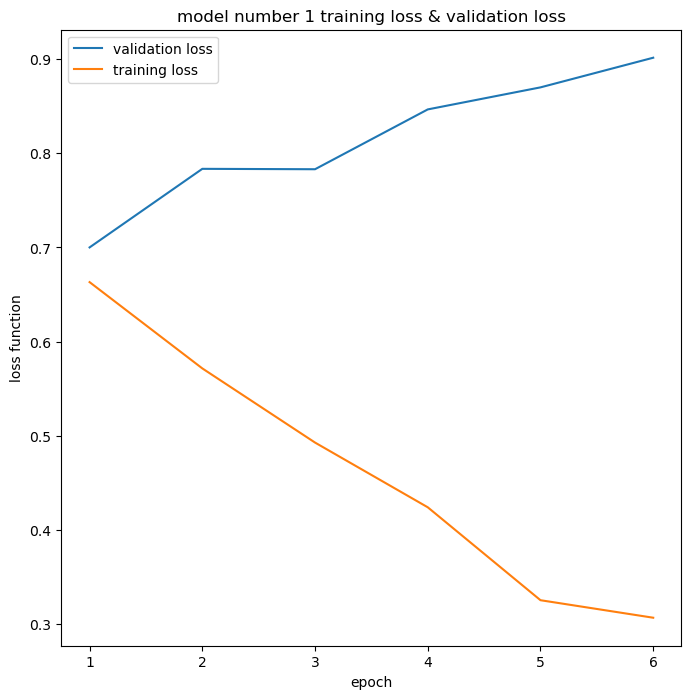

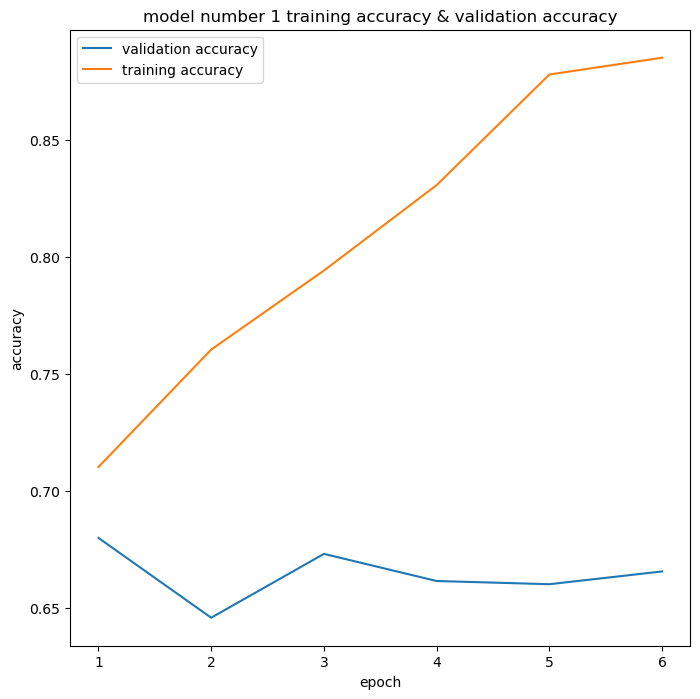

Epoch 1/50
367/367 [==============================] - 9s 23ms/step - loss: 0.5406 - price_loss: 0.7033 - type_loss: 0.5000 - price_sparse_categorical_accuracy: 0.6867 - type_sparse_categorical_accuracy: 0.8510 - val_loss: 0.7315 - val_price_loss: 0.7073 - val_type_loss: 0.7375 - val_price_sparse_categorical_accuracy: 0.6828 - val_type_sparse_categorical_accuracy: 0.8022 - lr: 0.0100
Epoch 2/50
367/367 [==============================] - 8s 23ms/step - loss: 0.4928 - price_loss: 0.6780 - type_loss: 0.4465 - price_sparse_categorical_accuracy: 0.6985 - type_sparse_categorical_accuracy: 0.8667 - val_loss: 0.7791 - val_price_loss: 0.7052 - val_type_loss: 0.7976 - val_price_sparse_categorical_accuracy: 0.6842 - val_type_sparse_categorical_accuracy: 0.7995 - lr: 0.0100
Epoch 3/50
367/367 [==============================] - 9s 24ms/step - loss: 0.4538 - price_loss: 0.6531 - type_loss: 0.4039 - price_sparse_categorical_accuracy: 0.7174 - type_sparse_categorical_accuracy: 0.8795 - val_loss: 0.7630

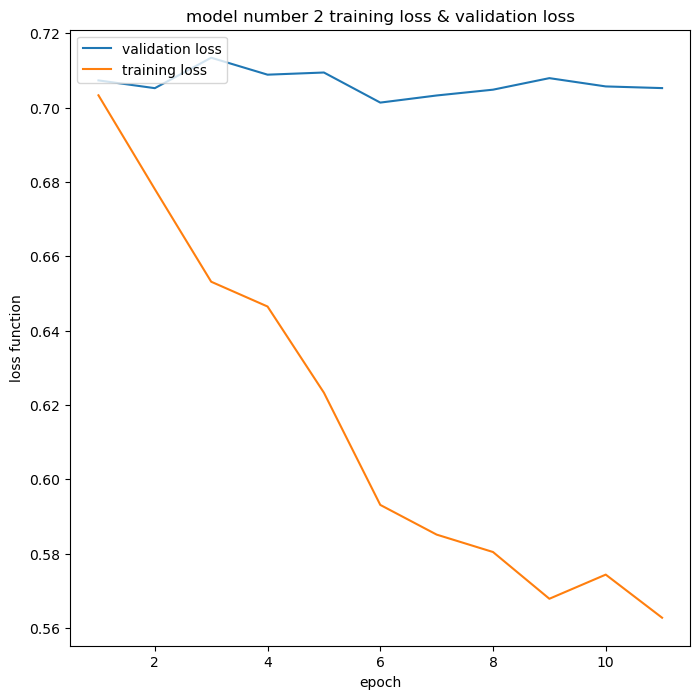

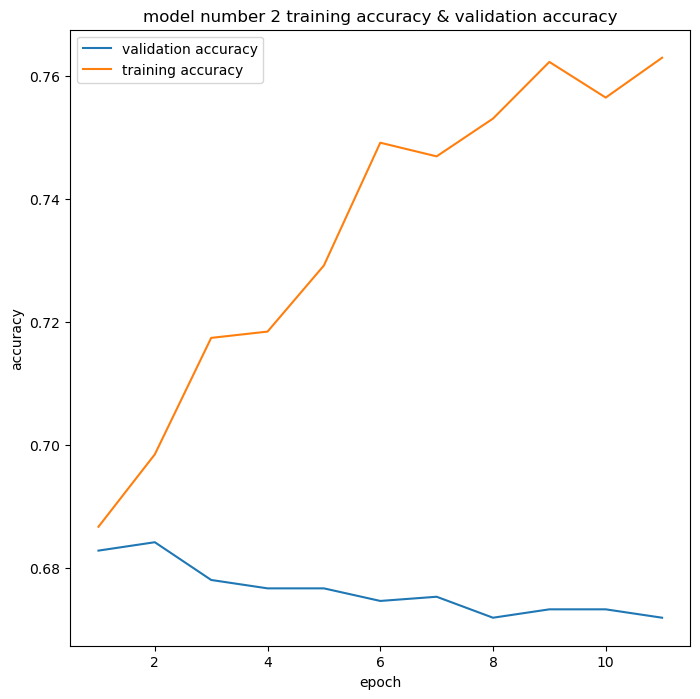

Epoch 1/50
367/367 [==============================] - 9s 24ms/step - loss: 0.5996 - price_loss: 0.7307 - type_loss: 0.5668 - price_sparse_categorical_accuracy: 0.6696 - type_sparse_categorical_accuracy: 0.8316 - val_loss: 0.7201 - val_price_loss: 0.7134 - val_type_loss: 0.7218 - val_price_sparse_categorical_accuracy: 0.6862 - val_type_sparse_categorical_accuracy: 0.8015 - lr: 0.0100
Epoch 2/50
367/367 [==============================] - 8s 22ms/step - loss: 0.5468 - price_loss: 0.7027 - type_loss: 0.5079 - price_sparse_categorical_accuracy: 0.6855 - type_sparse_categorical_accuracy: 0.8495 - val_loss: 0.7440 - val_price_loss: 0.7035 - val_type_loss: 0.7541 - val_price_sparse_categorical_accuracy: 0.6842 - val_type_sparse_categorical_accuracy: 0.7995 - lr: 0.0100
Epoch 3/50
367/367 [==============================] - 8s 23ms/step - loss: 0.4955 - price_loss: 0.6786 - type_loss: 0.4497 - price_sparse_categorical_accuracy: 0.7046 - type_sparse_categorical_accuracy: 0.8688 - val_loss: 0.7485

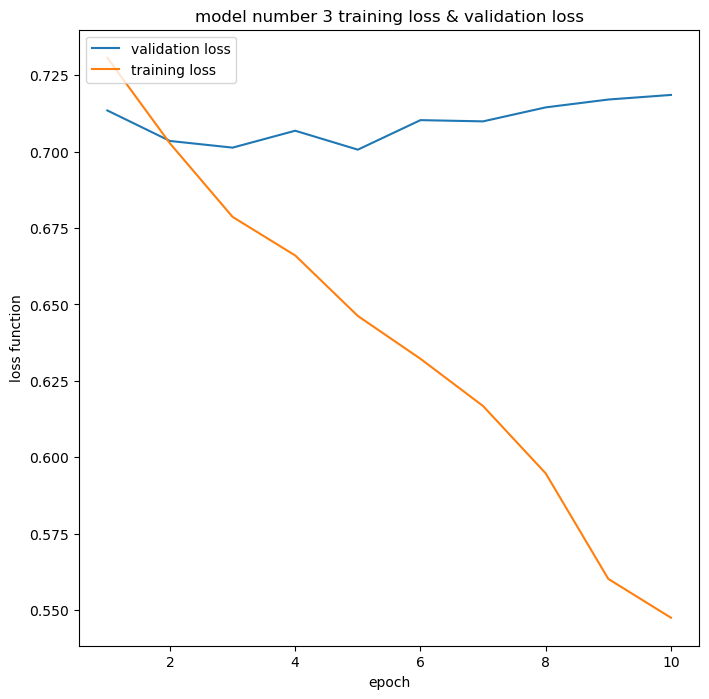

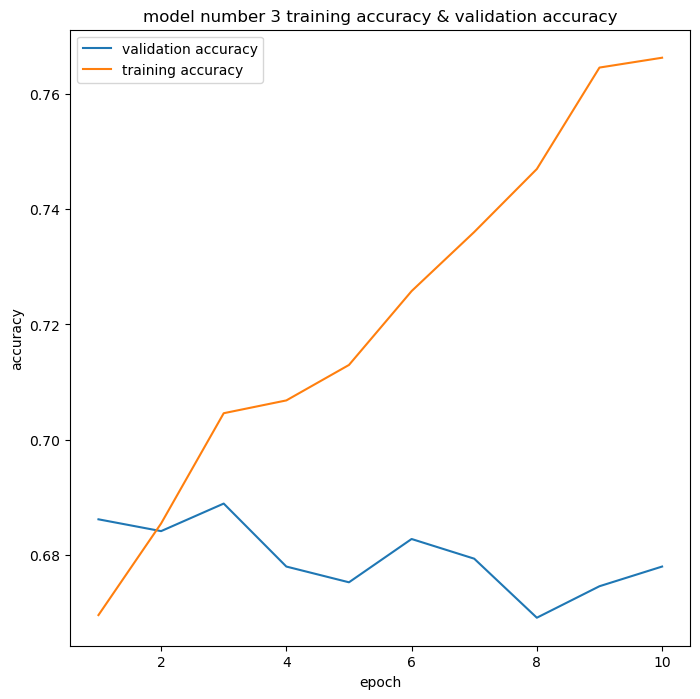

Epoch 1/50
367/367 [==============================] - 9s 23ms/step - loss: 0.2886 - price_loss: 0.6741 - type_loss: 0.2458 - price_sparse_categorical_accuracy: 0.7097 - type_sparse_categorical_accuracy: 0.9288 - val_loss: 0.8081 - val_price_loss: 0.7122 - val_type_loss: 0.8188 - val_price_sparse_categorical_accuracy: 0.6855 - val_type_sparse_categorical_accuracy: 0.8015 - lr: 0.0010
Epoch 2/50
367/367 [==============================] - 8s 22ms/step - loss: 0.2783 - price_loss: 0.6658 - type_loss: 0.2353 - price_sparse_categorical_accuracy: 0.7119 - type_sparse_categorical_accuracy: 0.9302 - val_loss: 0.8229 - val_price_loss: 0.7104 - val_type_loss: 0.8354 - val_price_sparse_categorical_accuracy: 0.6855 - val_type_sparse_categorical_accuracy: 0.7981 - lr: 0.0010
Epoch 3/50
367/367 [==============================] - 8s 23ms/step - loss: 0.2730 - price_loss: 0.6549 - type_loss: 0.2306 - price_sparse_categorical_accuracy: 0.7169 - type_sparse_categorical_accuracy: 0.9338 - val_loss: 0.8337

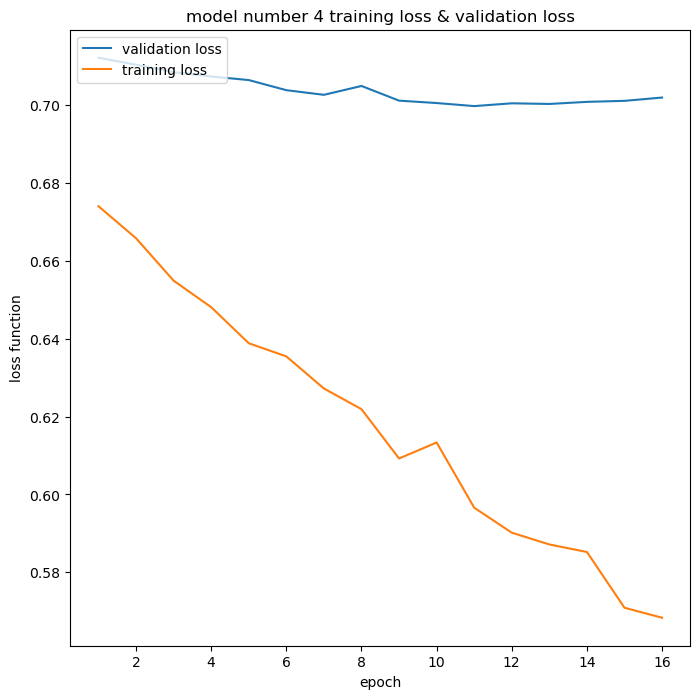

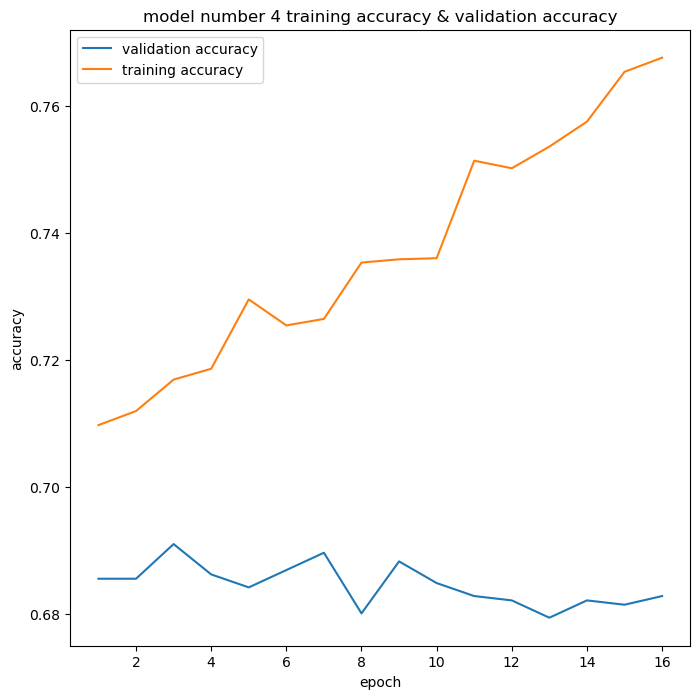

Epoch 1/50
367/367 [==============================] - 9s 23ms/step - loss: 0.6005 - price_loss: 0.6686 - type_loss: 0.5778 - price_sparse_categorical_accuracy: 0.7111 - type_sparse_categorical_accuracy: 0.8302 - val_loss: 0.7267 - val_price_loss: 0.7080 - val_type_loss: 0.7329 - val_price_sparse_categorical_accuracy: 0.6849 - val_type_sparse_categorical_accuracy: 0.7926 - lr: 0.0010
Epoch 2/50
367/367 [==============================] - 9s 23ms/step - loss: 0.5776 - price_loss: 0.6588 - type_loss: 0.5506 - price_sparse_categorical_accuracy: 0.7184 - type_sparse_categorical_accuracy: 0.8404 - val_loss: 0.7208 - val_price_loss: 0.7068 - val_type_loss: 0.7255 - val_price_sparse_categorical_accuracy: 0.6842 - val_type_sparse_categorical_accuracy: 0.7967 - lr: 0.0010
Epoch 3/50
367/367 [==============================] - 8s 22ms/step - loss: 0.5581 - price_loss: 0.6484 - type_loss: 0.5280 - price_sparse_categorical_accuracy: 0.7253 - type_sparse_categorical_accuracy: 0.8462 - val_loss: 0.7179

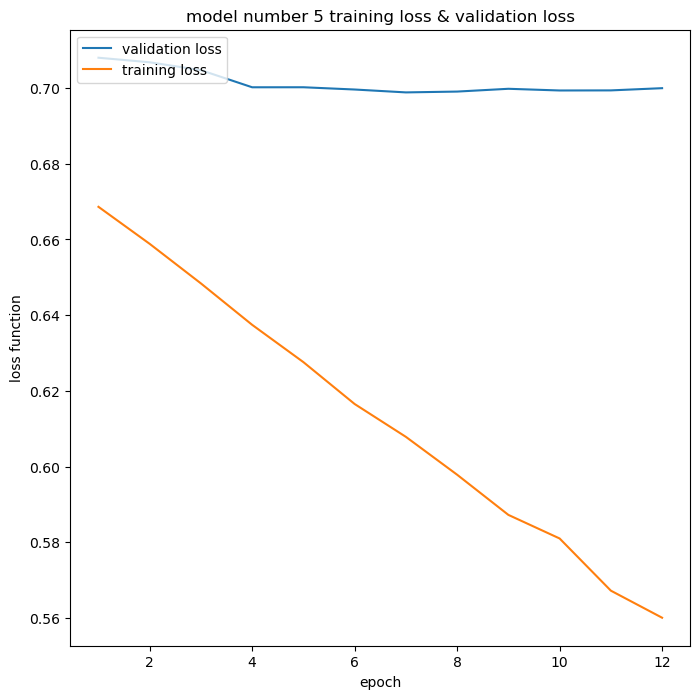

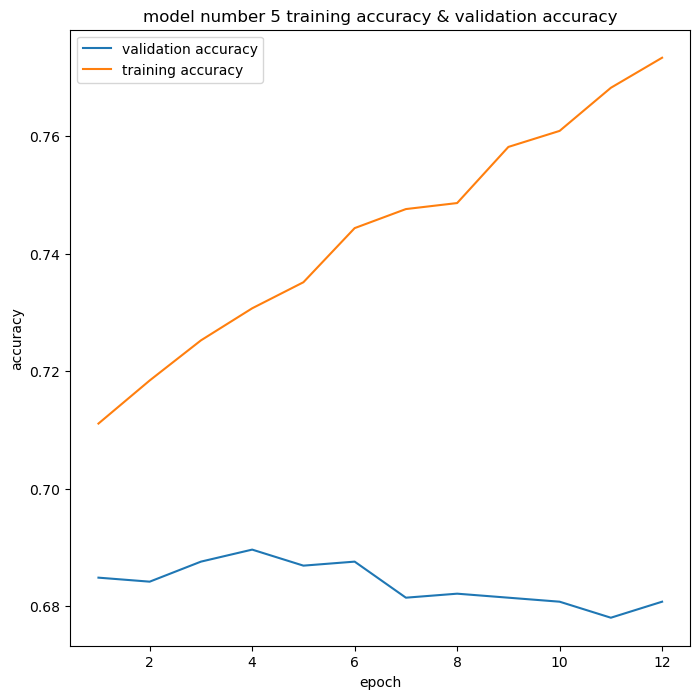

In [47]:
list_OF_Val_Loss=[]
list_OF_Loss=[]
list_Val_accuracy=[]
list_accuracy=[]

best_model = tuner.get_best_models(num_models=5)[:]
for i in range (5):
    best_model[i].build(x_train_text_id.shape)
    history=best_model[i].fit(
    x={
        'summary': x_train_text_id    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, restore_best_weights=True ),
        ReduceLROnPlateau(monitor='val_price_loss',patience=3,verbose=1,factor=0.2,min_lr=1e-6)
    ],
    verbose=1
)

    val_loss_per_epoch = history.history['val_price_loss']
    loss_per_epoch = history.history['price_loss']
    val_accuracy_per_epoch = history.history['val_price_sparse_categorical_accuracy']
    accuracy_per_epoch = history.history['price_sparse_categorical_accuracy']

    list_OF_Val_Loss.append(val_loss_per_epoch)
    list_OF_Loss.append(loss_per_epoch)
    list_Val_accuracy.append(val_accuracy_per_epoch)
    list_accuracy.append(accuracy_per_epoch)

    plt.figure(figsize=(8,8))
    plt.title(f"model number {i+1} training loss & validation loss")
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.plot(np.arange(1,len(val_loss_per_epoch)+1),val_loss_per_epoch,label="validation loss")
    plt.plot(np.arange(1,len(loss_per_epoch)+1),loss_per_epoch,label = "training loss")
    plt.legend(loc="upper left")
    plt.show()

    plt.figure(figsize=(8,8))
    plt.title(f"model number {i+1} training accuracy & validation accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(np.arange(1,len(val_accuracy_per_epoch)+1),val_accuracy_per_epoch,label="validation accuracy")
    plt.plot(np.arange(1,len(accuracy_per_epoch)+1),accuracy_per_epoch,label = "training accuracy")
    plt.legend(loc="upper left")
    plt.show()


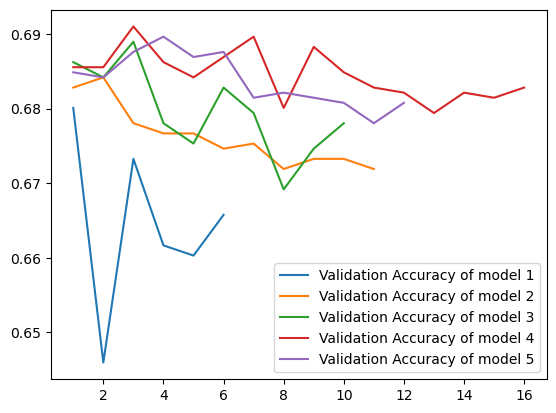

In [48]:
# here we plot the first fifth models for compare Validation Accuracy
for i in range (5):
    plt.plot(np.arange(1,len(list_Val_accuracy[i])+1), list_Val_accuracy[i], label = "Validation Accuracy of model "+str(i+1))
plt.legend()
plt.show()

In [51]:
#start predicting the values of type and price using summary and image as inputs
prediction1 = best_model[0].predict(
    {
        'summary': x_test_text
    }
)


# probabilities
prediction1 = prediction1['price']
print(prediction1)

# categories
prediction1 = np.argmax(prediction1, axis=1)
print(prediction1)

230/230 [==============================] - 0s 941us/step
[[0.5791605  0.3457979  0.07504157]
 [0.9325986  0.06031795 0.0070835 ]
 [0.7493681  0.20635334 0.04427858]
 ...
 [0.7118373  0.25849712 0.02966556]
 [0.9432841  0.04690058 0.00981532]
 [0.71725935 0.25385228 0.02888839]]
[0 0 0 ... 0 0 0]


In [ ]:
#start predicting the values of type and price using summary and image as inputs
prediction2 = best_model[1].predict(
    {
        'summary': x_test_text
    }
)


# probabilities
prediction2 = prediction2['price']
print(prediction2)

# categories
prediction2 = np.argmax(prediction2, axis=1)
print(prediction2)

In [53]:
#start predicting the values of type and price using summary and image as inputs
prediction3 = best_model[2].predict(
    {
        'summary': x_test_text
    }
)


# probabilities
prediction3 = prediction3['price']
print(prediction3)

# categories
prediction3 = np.argmax(prediction3, axis=1)
print(prediction3)

230/230 [==============================] - 0s 997us/step
[[0.6133791  0.30794406 0.07867692]
 [0.9366963  0.05641772 0.00688605]
 [0.72139657 0.20182176 0.07678152]
 ...
 [0.7262174  0.24045916 0.03332343]
 [0.931301   0.05870882 0.00999026]
 [0.7335932  0.23566674 0.03074001]]
[0 0 0 ... 0 0 0]


In [52]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': prediction1}
).to_csv('f1.csv', index=False)

In [ ]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': prediction2}
).to_csv('f2.csv', index=False)

In [54]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': prediction3}
).to_csv('f3.csv', index=False)

In [49]:
#start predicting the values of type and price using summary and image as inputs
prediction4 = best_model[3].predict(
    {
        'summary': x_test_text
    }
)


# probabilities
prediction4 = prediction4['price']
print(prediction4)

# categories
prediction4 = np.argmax(prediction4, axis=1)
print(prediction4)

230/230 [==============================] - 0s 919us/step
[[0.59917283 0.29954082 0.10128636]
 [0.93648225 0.05270273 0.01081482]
 [0.7263795  0.19523251 0.07838807]
 ...
 [0.7455593  0.20846803 0.04597268]
 [0.935325   0.0500378  0.01463715]
 [0.67856723 0.25967175 0.06176085]]
[0 0 0 ... 0 0 0]


In [50]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': prediction4}
).to_csv('f4.csv', index=False)

In [55]:
#start predicting the values of type and price using summary and image as inputs
prediction4 = best_model[4].predict(
    {
        'summary': x_test_text
    }
)


# probabilities
prediction4 = prediction4['price']
print(prediction4)

# categories
prediction4 = np.argmax(prediction4, axis=1)
print(prediction4)

230/230 [==============================] - 0s 958us/step
[[0.6138814  0.2912398  0.09487879]
 [0.9223703  0.06370163 0.01392797]
 [0.7374916  0.18924135 0.07326703]
 ...
 [0.7532705  0.20315073 0.0435788 ]
 [0.91581035 0.06474212 0.01944758]
 [0.67936975 0.26647696 0.05415323]]
[0 0 0 ... 0 0 0]


In [56]:
pd.DataFrame(
    {'id': test_df['id'],
     'price': prediction4}
).to_csv('f5.csv', index=False)

sadly none of the 5 best tuned model passed the first submision but they were still close :(

maybe if i have enough time the next thing i will try to do is to tune the transfer learning model maybe it can improve more